In [1]:
import matplotlib.pyplot
from catboost import Pool,CatBoostClassifier
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold , KFold
import matplotlib.pyplot as plt
import numpy as np
import optuna
import lightgbm as lgbm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from typing import List ,Dict, Tuple
from sklearn.metrics import log_loss
import lightgbm as lgbm
from optuna import trial
from optuna.integration import LightGBMPruningCallback
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
from optuna.trial import Trial

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:


DATA_PATH = './JobCare_data/'
#train = pd.read_csv('./JobCare_data/train.csv')
code_d = pd.read_csv(f'{DATA_PATH}속성_D_코드.csv')
code_h = pd.read_csv(f'{DATA_PATH}속성_H_코드.csv')
code_l = pd.read_csv(f'{DATA_PATH}속성_L_코드.csv')
train_data = pd.read_csv(f'{DATA_PATH}train.csv')
test_data = pd.read_csv(f'{DATA_PATH}test.csv')

In [3]:
code_h

,속성 H 코드,속성 H 중분류코드,속성 H 대분류코드
0,2,315,1
1,4,316,3
2,5,317,3
3,6,318,3
4,7,319,3
...,...,...,...
289,309,566,308
290,310,567,308
291,311,568,308
292,313,569,312


In [4]:
ordinal_cols = ['person_attribute_a_1','person_attribute_b', 'person_prefer_e', 'contents_attribute_e']
nominal_cols = ['person_attribute_a_1','person_attribute_b','person_prefer_e','contents_attribute_e']

In [5]:
code_h

,속성 H 코드,속성 H 중분류코드,속성 H 대분류코드
0,2,315,1
1,4,316,3
2,5,317,3
3,6,318,3
4,7,319,3
...,...,...,...
289,309,566,308
290,310,567,308
291,311,568,308
292,313,569,312


In [6]:
code_d.columns= ["attribute_d","attribute_d_d","attribute_d_s","attribute_d_m","attribute_d_l"]
code_h.columns= ["attribute_h","attribute_h_m","attribute_h_l"]
code_l.columns= ["attribute_l","attribute_l_d","attribute_l_s","attribute_l_m","attribute_l_l"]
# 오버피팅이 자주 발생하는 mean encoding 이므로 cross validation 과 정규화 같이 사용한다=
# 변환 하고자 하는 범주형 변수 선택
# 범주형 변수 그룹화 -> 타깃 변수 총합 합계
# 범주형 변수 그룹화 타깃 빈도수 합계
# 총합을 카운트로 나누고 본래 범주 값에 업데이트
# 여러가지 방법으로 적용 가능하다
# 비슷한 범주 사이에 있는 관계 표현 특징, 범주와 타깃사이에만 국한된다
# 범주가 많은 경우 이 방법은 데이터를 훨씬 더 단순화 한다

In [7]:
code_d.columns



Index(['attribute_d', 'attribute_d_d', 'attribute_d_s', 'attribute_d_m',
       'attribute_d_l'],
      dtype='object')

In [8]:
# 소분류 중분류 대분류 속성코드 merge 컬럼명 및 데이터 프레임 리스트
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
]

In [60]:
code_h

,attribute_h,attribute_h_m,attribute_h_l
0,2,315,1
1,4,316,3
2,5,317,3
3,6,318,3
4,7,319,3
...,...,...,...
289,309,566,308
290,310,567,308
291,311,568,308
292,313,569,312


In [9]:
# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
# cols_merge 으로 생성된 컬럼으로 비교한다
cols_equi = [

    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),

    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_h_1_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_1_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_2_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_2_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_3_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_3_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
]

,attribute_l,attribute_l_d,attribute_l_s,attribute_l_m,attribute_l_l
0,1,1,1,1,2004
1,2,2,2,1,2004
2,3,3,2,1,2004
3,4,3,2,1,2004
4,5,5,2,1,2004
...,...,...,...,...,...
2020,2021,2021,2021,2021,2021
2021,2022,2022,2022,2022,2022
2022,2023,2023,2023,2023,2023
2023,2024,2024,2024,2024,2024


In [10]:
# 학습에 필요없는 컬럼 리스트 눈이 삐었나
cols_drop = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt", "contents_rn", ]

In [11]:
train_data.drop(['id','contents_open_dt','contents_rn','person_rn'],axis=1)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,target
0,True,True,True,False,False,False,1,4,3,5,...,10,2,1,2,1608,275,1,4,139,1
1,False,False,False,True,True,False,1,3,4,1,...,5,1,1,2,1608,275,1,4,133,0
2,False,False,False,True,False,False,2,0,3,5,...,10,2,1,1,1600,94,1,4,53,0
3,False,False,False,True,False,False,2,0,2,5,...,5,1,1,2,1608,275,5,3,74,0
4,True,True,True,False,False,False,1,3,4,5,...,10,2,1,2,1608,275,1,4,74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,...,5,1,1,2,354,147,1,5,65,1
501947,True,True,False,True,False,False,1,6,2,1,...,10,2,1,2,163,120,1,4,142,1
501948,True,True,True,True,False,False,1,7,4,1,...,5,1,1,2,438,147,2,7,65,1
501949,True,False,False,True,False,False,1,1,2,1,...,5,1,1,2,660,147,3,4,259,1


In [12]:
# 회원 선호 속성 1 ,2 ,3 이라는게 우선 순위 인듯 하다 계속 보다보니
train_data['person_prefer_h_3']

0          59
1          96
2          56
3           2
4         209
         ... 
501946     95
501947     95
501948    139
501949    258
501950     49
Name: person_prefer_h_3, Length: 501951, dtype: int64

In [13]:
def merge_codes(df:pd.DataFrame,df_code:pd.DataFrame,col:str)->pd.DataFrame:
    df = df.copy()
    df_code = df_code.copy()

    # 속성 코드에 대해 검사하는 컬럼별로 prefix 를 붙인다
    #
    df_code = df_code.add_prefix(f"{col}_")
    df_code.columns.values[0] = col
    return pd.merge(df,df_code,how="left",on=col)

In [66]:
# def merge_codes(df:pd.DataFrame, df_code:pd.DataFrame, col:str) -> pd.DataFrame:
#     df = df.copy()
#     df_code = df_code.copy()
#     df_code = df_code.add_prefix(f"{col}_")
#     # join key 설정
#     df_code.columns.values[0] = col
#     # print('df :' ,df)
#     # print('df_code : ', df_code)
#     # print('merge data : ',pd.merge(df,df_code , how='left', on= col) )
#     return pd.merge(df,df_code , how='left', on= col)

Int64Index([  2, 198, 215, 214, 213, 212, 211, 210, 209, 207,
            ...
            113, 111, 104, 110, 109, 108, 107, 106, 105, 314],
           dtype='int64', length=294)

In [14]:
def preprocess_data(
                    df:pd.DataFrame,is_train:bool = True, cols_merge:List[Tuple[str,pd.DataFrame]] = []  , cols_equi:List[Tuple[str,str]]= [] ,
                    cols_drop:List[str] = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt"]
                    )->Tuple[pd.DataFrame,np.ndarray]:
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    for col, df_code in cols_merge:
        df = merge_codes(df,df_code,col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    return (df , y_data)

In [15]:
def get_meta_data(train_data):
    cols = train_data.columns
    temp =[]
    binary_col = []
    nominal_col = []
    ordinal_col = []
    for col in cols:
        if 'yn' in col:
            temp.append((col,'binary'))
        elif col in ordinal_cols:
            temp.append((col,'ordinal'))
        else:
            temp.append((col,'nominal'))

    temp = pd.DataFrame(data)

    temp.columns = ['col_name', 'type']
    return temp

In [16]:
x_train, y_train = preprocess_data(train_data,  cols_merge=cols_merge, cols_equi=cols_equi, cols_drop=cols_drop)

In [17]:
x_test , _ = preprocess_data(test_data, is_train  =False , cols_merge= cols_merge, cols_equi= cols_equi, cols_drop = cols_drop)


In [18]:
x_train.shape, y_train.shape , x_test.shape

((501951, 71), (501951,), (46404, 71))

In [19]:
cat_features = x_train.columns[x_train.nunique() > 2].tolist()


In [20]:
cat_features

['person_attribute_a_1',
 'person_attribute_b',
 'person_prefer_c',
 'person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_e',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_1',
 'contents_attribute_c',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_m',
 'contents_attribute_e',
 'contents_attribute_h',
 'person_rn',
 'person_prefer_d_1_attribute_d_d',
 'person_prefer_d_1_attribute_d_s',
 'person_prefer_d_1_attribute_d_m',
 'person_prefer_d_1_attribute_d_l',
 'person_prefer_d_2_attribute_d_d',
 'person_prefer_d_2_attribute_d_s',
 'person_prefer_d_2_attribute_d_m',
 'person_prefer_d_2_attribute_d_l',
 'person_prefer_d_3_attribute_d_d',
 'person_prefer_d_3_attribute_d_s',
 'person_prefer_d_3_attribute_d_m',
 'person_prefer_d_3_attribute_d_l',
 'contents_attribute_d_attribute_d_d',
 'contents_attribute_d_attribute_d_s',
 'contents_attribute_d_attrib

In [21]:
SEED=42
isholdout = False
n_splits = 5
iterations = 3000
patience = 50

cv = KFold(n_splits=n_splits, shuffle=True , random_state=SEED)

In [23]:
scores = []
models = []

is_holdout =False
models = []
for tri , vai in cv.split(x_train):
    print("="*50)
    preds = []

    model = CatBoostClassifier(iterations=iterations  ,random_state=SEED , eval_metric="F1", cat_features=cat_features,
                               one_hot_max_size=4, )
    model.fit(x_train.iloc[tri], y_train[tri],
              eval_set=[(x_train.iloc[vai] , y_train[vai])],
              early_stopping_rounds=patience,
              verbose =100
              )
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.086395
0:	learn: 0.6065167	test: 0.6062566	best: 0.6062566 (0)	total: 2.24s	remaining: 1h 51m 55s
100:	learn: 0.6633278	test: 0.6867998	best: 0.6867998 (100)	total: 3m 22s	remaining: 1h 37m 2s
200:	learn: 0.6695217	test: 0.6900888	best: 0.6903794 (179)	total: 6m 52s	remaining: 1h 35m 44s
300:	learn: 0.6735240	test: 0.6921928	best: 0.6922372 (287)	total: 10m 33s	remaining: 1h 34m 36s
400:	learn: 0.6760803	test: 0.6929551	best: 0.6929551 (400)	total: 13m 26s	remaining: 1h 27m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6929551329
bestIteration = 400

Shrink model to first 401 iterations.
Learning rate set to 0.086395
0:	learn: 0.5957885	test: 0.6076535	best: 0.6076535 (0)	total: 2.82s	remaining: 2h 21m 6s
100:	learn: 0.6630940	test: 0.6867308	best: 0.6868377 (95)	total: 3m 16s	remaining: 1h 34m 7s
200:	learn: 0.6691893	test: 0.6915610	best: 0.6918382 (191)	total: 7m 1s	remaining: 1h 37m 54s
300:	learn: 0.6727952	test: 0.6951114	best: 0.69

In [ ]:
train_data

In [25]:
#https://soobarkbar.tistory.com/34 catboost explain
#cat boost work 현재 트리 이전에 사용된 모든 범주형 feature를 조합한다 그리고 연결한다
# 작은 데이터셋에서 ORDERED 모드가 유용 데이터 특질 이해하기
print(scores)
print(np.mean(scores))
threshold=0.4

[]
nan


/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/seongminpark/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
from sklearn.metrics import f1_score
pred_list =[]
scores=[]

for i , (tri, vai) in enumerate(cv.split(x_train)):
    pred = models[i].predict_proba(x_train.iloc[vai])[:,1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai], pred)
    scores.append(score)
    pred = models[i].predict_proba(x_test)[:,1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))

[0.718845786229854, 0.7172267536704731, 0.7102823177414579, 0.7153543147208121, 0.7103137267624824]
0.7144045798250158


In [28]:
pred = np.mean(pred_list, axis=0)
pred = np.where(pred >= threshold, 1,0)

In [29]:
sample_submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")
sample_submission['target'] = pred
sample_submission

,id,target
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
46399,46399,1
46400,46400,1
46401,46401,1
46402,46402,1


In [32]:
SUBMIT_PATH = './submission/'
sample_submission.to_csv(f"{SUBMIT_PATH}prediction.csv", index=False)

In [36]:
from optuna.samplers import TPESampler

In [33]:
# optuna hyperparameter tuning
# 일반 데이터셋에서 best parameter 를 추출하고 catboost에 다시 적용

x_train.shape, y_train.shape

(501951, 71)

In [41]:
def objective(trial):
  param = {
      "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      "used_ram_limit": "2gb",
  }

  X_train, X_valid, Y_train, Y_valid = train_test_split(x_train,y_train,test_size=0.2)

  cat_features =[0,1,2,5,6,7,8,15,18]
  cat = CatBoostClassifier(**param)
  cat.fit(X_train, Y_train,
          eval_set=[ (X_valid,Y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(Y_valid, cat_pred)

  return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-01-26 23:50:00,036] A new study created in memory with name: cat_parameter_opt
CatBoost is using more CPU RAM (2.73GiB) than the limit (2GiB)
CatBoost is using more CPU RAM (2.73GiB) than the limit (2GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1667920) > ResourceQuota(0)
Resource CPU 

0:	learn: 0.6884558	test: 0.6884648	best: 0.6884648 (0)	total: 332ms	remaining: 13m 18s
100:	learn: 0.6552317	test: 0.6566346	best: 0.6566346 (100)	total: 21.4s	remaining: 8m 8s
200:	learn: 0.6455188	test: 0.6484221	best: 0.6484221 (200)	total: 42.7s	remaining: 7m 47s
300:	learn: 0.6402046	test: 0.6452321	best: 0.6452321 (300)	total: 1m 4s	remaining: 7m 29s
400:	learn: 0.6361480	test: 0.6436568	best: 0.6436568 (400)	total: 1m 25s	remaining: 7m 8s
500:	learn: 0.6324935	test: 0.6423112	best: 0.6423112 (500)	total: 1m 47s	remaining: 6m 46s
600:	learn: 0.6291614	test: 0.6414226	best: 0.6414226 (600)	total: 2m 8s	remaining: 6m 26s
700:	learn: 0.6262126	test: 0.6409973	best: 0.6409973 (700)	total: 2m 30s	remaining: 6m 4s
800:	learn: 0.6233830	test: 0.6404102	best: 0.6403989 (799)	total: 2m 51s	remaining: 5m 43s
900:	learn: 0.6205586	test: 0.6400788	best: 0.6400575 (894)	total: 3m 13s	remaining: 5m 23s
1000:	learn: 0.6178037	test: 0.6397558	best: 0.6397454 (996)	total: 3m 35s	remaining: 5m 1s

CatBoost is using more CPU RAM (3.12GiB) than the limit (2GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608)

0:	learn: 0.6911580	test: 0.6912120	best: 0.6912120 (0)	total: 378ms	remaining: 22m 47s
100:	learn: 0.6611166	test: 0.6661091	best: 0.6661091 (100)	total: 1m 22s	remaining: 47m 55s
200:	learn: 0.6542939	test: 0.6627736	best: 0.6627736 (200)	total: 2m 47s	remaining: 47m 27s
300:	learn: 0.6465254	test: 0.6581029	best: 0.6580791 (299)	total: 4m 22s	remaining: 48m 16s
400:	learn: 0.6405370	test: 0.6564741	best: 0.6564632 (396)	total: 6m 45s	remaining: 54m 20s
500:	learn: 0.6377637	test: 0.6564283	best: 0.6562905 (475)	total: 9m	remaining: 56m 15s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6562904848
bestIteration = 475

Shrink model to first 476 iterations.


CatBoost is using more CPU RAM (2.21GiB) than the limit (2GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(32572608)

0:	learn: 0.6925847	test: 0.6927672	best: 0.6927672 (0)	total: 1.54s	remaining: 4h 8m 30s
100:	learn: 0.6677383	test: 0.6744194	best: 0.6744194 (100)	total: 1m 14s	remaining: 1h 58m 35s
200:	learn: 0.6573773	test: 0.6681034	best: 0.6681034 (200)	total: 2m 35s	remaining: 2h 2m 38s


In [ ]:
# 사람 속성 , 속성 대분류 컬럼명
# ex ) person_prefer_h_3, attribute_h_l -> person_prefer_h_3_attribute_h_l
# -> person_prefer_h_3 에 대한 속성 h 대분류

In [78]:
x_train['person_prefer_h_3']

0          59
1          96
2          56
3           2
4         209
         ... 
501946     95
501947     95
501948    139
501949    258
501950     49
Name: person_prefer_h_3, Length: 501951, dtype: int64

In [79]:
x_train['person_prefer_h_3_attribute_h_l']

0          58
1          94
2          48
3           1
4         208
         ... 
501946     94
501947     94
501948     94
501949    250
501950     48
Name: person_prefer_h_3_attribute_h_l, Length: 501951, dtype: int64

In [ ]:
from varname import nameof

In [70]:
test_data.columns

Index(['id', 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_f', 'person_prefer_g',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn', 'contents_open_dt'],
      dtype='object')

In [39]:
# feature 각 value 별 target columns에 대한 평균 값
#pd.DataFrame(test_data.groupby('person_attribute_a_1')['contents_attribute_l_l'].mean())

In [40]:
def get_mean_encode(train, nominal_cols):

    for col in nominal_cols:
        if 'attribute' in col:
            name = col[col.index('attribute') + len('attribute')+1:]
            var_name = 'attr_{}_mean_encode'.format(name)
            #var_name = f'attr_{name}_mean_encode'
            # target 값을 기반으로 만드는 feature
            # groupby 는 col의 value 별 [target column]에 대한 mean , max 등의 연산을 지원한다

            locals()[var_name] = train.groupby(col)["target"].mean()

        elif 'prefer' in col:
            name = col[col.index('prefer') + len('prefer')+1:]
            var_name = 'prefer_{}_mean_encode'.format(name)

            locals()[var_name] = train.groupby(col)["target"].mean()

        train.loc[:,var_name] = train[col].map(locals()[var_name])
    return train

In [41]:
def objective(trial,X,y):
    param_grid = {
        # "device_type" : trial.suggest_categorical("device_type",['gpu']),
        "learning_rate" : trial.suggest_float("learning_rate", 0.1, 0.95, step=0.1 ),
        "num_leaves" : trial.suggest_int("num_leaves", 5, 100 ,step=5),
        "max_depth" : trial.suggest_int("max_depth", 1,30 , step=3),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf" ,50 , 1000 , step=50),
        "lambda_l1" : trial.suggest_int("lambda_l1", 0,100 , step=5),
        "lambda_l2" : trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split" : trial.suggest_float("min_datin_to_split" , 1,30, step=3),
        "bagging_fraction" : trial.suggest_float("bagging_fraction" , 0.1,0.99,step=0.1),
        "bagging_freq" : trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction" : trial.suggest_float("feature_fraction", 0.1,0.99,step=0.1),
        "n_estimators" : trial.suggest_int("n_estimators",10,2000, step=10),
    }
    cv=  StratifiedKFold(n_splits=5, shuffle=False)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx ) in enumerate(cv.split(X,y)):
        X_train , X_test = X.iloc[train_idx] , X.iloc[test_idx]
        y_train , y_test = y[train_idx] , y[test_idx]
        model = lgbm.LGBMClassifier(objective="binary" , **param_grid)

        model.fit(
            X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            eval_metric = "binary_logloss",
            early_stopping_rounds =100,
            callbacks= [
                LightGBMPruningCallback(trial, "binary_logloss")
            ], # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test,preds)

    #return np.mean(f1_scores)
    return np.mean(cv_scores)

In [ ]:
# :::::::::::: META DATA MAKE :::::::::::::::::::
data = get_meta_data(train_data)
# :::::::::::: META DATA MAKE END :::::::::::::::::::
# get mean_encdoe train set
train = get_mean_encode(train, nominal_cols)
target = train.target
# drop target , contetns_open_dt, id
train = train.drop(['contents_open_dt','id','target'],axis=1)
x_train, x_valid, y_train, y_valid = train_test_split(train,target , test_size=0.3 , shuffle=True, stratify=target, random_state=34)
# gradient boosting 이 randomforest 보다 좋다고 알려져있다
rf= RandomForestClassifier(n_estimators=150 , max_depth=8 , min_samples_split=4, max_features=0.2, n_jobs=-1 ,random_state=0)
rf.fit(x_train,y_train)

In [ ]:
# :::::::::::: HYPER PARAMETER OPTUNA START  LGBM CLASSIFIER:::::::::::::::::::::::
# mean encode값 랜포보다 성능좋다고 알려진 Lightgbm에 넣기
study = optuna.create_study(direction="minimize" , study_name = "LGBM Classifier")
func = lambda trial: objective(trial,train,target )
study.optimize(func,n_trials=20)
Trial.suggest_float(name="learning_rate",low= 0.1 ,high=0.95, step=0.1 )
trial = Trial()
trial.suggest_float(name="learning_rate",low= 0.1 ,high=0.95, step=0.1 )
# trial suggest_float 메서드는 self 가 필요한데 이렇게 익명함수 명을 함수명으로 해서 다른 함수의 인자로 넘기면 가능한가 ?
train = train.drop(['person_rn','contents_rn'], axis=1)
# 과적합일진 모르지만 그래도많이올랐따 만족할 수 없음
# 0.57정도에서 0.59 정도로 mean encoding 으로 상승 -> 랜포말고 다른건 ?

# :::::::::::: HYPER PARAMETER OPTUNA END  LGBM CLASSIFIER:::::::::::::::::::::::

In [73]:
# 시작과 끝을 잘 경계짓고 , 범주를 잘 정리 변수의 위치 등

In [ ]:
#define dataset
y = y_train.values.tolist()
# make regression to fit catboostregressor!
X, y = make_regression(n_samples=1000, n_features=10 , n_informative=5, random_state=1)
#evaluate the model
model = CatBoostRegressor(verbose=0 , n_estimators=100)
cv = RepeatedKFold(n_splits= 10 , n_repeats=3 , random_state=1)
n_scores = cross_val_score(model, X,y , scoring='neg_mean_absolute_error', cv=cv)
print('MAE : %.3f (%.3f)'  % (mean(n_scores), std(n_scores)))
#fit the model on the whole dataset
model.fit(X,y)
# make a single prediction
row = x_valid[[col for col in x_train.columns if 'mean_encode' in col]].values.tolist()
#row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
# make a single prediction
yhat = model.predict(row)
print('Prediction: %.3f' % yhat[0])
(yhat == y_valid.values.tolist()).mean()
#::::::::::::: CATBOOSTREGRESSOR END :::::::::::::::::::::#
#catboost + cv 5fold + threshold

In [1]:
#Backward difference 코딩에서
# #수준에 대한 종속 변수의 평균은 이전 수준에 대한 종속 변수의 평균과 비교됩니다. 이러한 유형의 코딩은 명목 또는 순서 변수에 유용할 수 있습니다.'
#In backward difference coding,
# the mean of the dependent variable for a level is
# compared with the mean of the dependent variable for the prior level.
# This type of coding may be useful for a nominal or an ordinal variable.'

#::::::::::::: SEABORN DATA PLOT START::::::::::::::::#
fig, ax = plt.subplots(5,1,figsize=(10,20))
for i in range(len(ordinal_cols)):
    print(train_data[ordinal_cols[i]].value_counts())
    sns.histplot(train_data[ordinal_cols[i]].values ,ax=ax[i])
#::::::::::::: SEABORN DATA PLOT END::::::::::::::::#

# 하나는 있는 거니까 , left merge는 있는 컬럼키면 그대로두고
# 없는 컬럼 키면 그대로 붙이니까 merge가 가능하다

In [28]:
#:::::::::::::
List[Tuple[str,pd.DataFrame]]
# type hinting , type annotation 타입에 대한 메타 정보를 제공한다 중대규모 이상프로젝트에서는 컴파일 위험 에러

df :             id  d_l_match_yn  d_m_match_yn  d_s_match_yn  h_l_match_yn  \
0            0          True          True          True         False   
1            1         False         False         False          True   
2            2         False         False         False          True   
3            3         False         False         False          True   
4            4          True          True          True         False   
...        ...           ...           ...           ...           ...   
501946  501946         False         False         False          True   
501947  501947          True          True         False          True   
501948  501948          True          True          True          True   
501949  501949          True         False         False          True   
501950  501950          True          True          True          True   

        h_m_match_yn  h_s_match_yn  person_attribute_a  person_attribute_a_1  \
0              False      

KeyError: 'person_prefer_d_2_attribute_d_s'

[('person_prefer_d_1',
        attribute_d  attribute_d_d  attribute_d_s  attribute_d_m  attribute_d_l
  0               4              4              3              2              1
  1               5              5              3              2              1
  2               7              7              6              2              1
  3               8              8              6              2              1
  4               9              8              6              2              1
  ...           ...            ...            ...            ...            ...
  1109         1254           1254           1254           1235           1235
  1110         1255           1254           1254           1235           1235
  1111         1256           1254           1254           1235           1235
  1112         1257           1254           1254           1235           1235
  1113         1258           1258           1258           1258           1258
  
  [1114 rows x

In [ ]:
# 학습에 필요없는 컬럼 리스트
cols_drop = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt", "contents_rn", ]
x_train, y_train = preprocess_data(train_data, cols_merge = cols_merge , cols_equi= cols_equi , cols_drop = cols_drop)

In [ ]:
x_test, _ = preprocess_data(test_data,is_train = False, cols_merge = cols_merge , cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape
x_train  = x_train.iloc[:351365,:]
y_train = y_train[:351365]
mean_encode = x_train[[col for col in x_train.columns if 'mean_encode' in col]]
#left는 그래도 on key 가 하나는 있어야 없어도 붙인다
x_train
mean_encode =  mean_encode.reset_index(drop=True)
#x_train = pd.concat([x_train, mean_encode],axis=1 ) catboost 에 , test 셋에도 없는 mean encode 사용하지 않는다
x_train.columns[x_train.nunique() > 2 ].tolist()
# 범주형 컬럼 리스트
is_holdout = False
n_splits = 5

In [167]:
iterations = 3000
patience= 50
SEED = 42
# 전역 변수
scores = []
models = []
# category feature 가 아니지만 쓰였으므로

In [169]:
cat_features = x_train.columns[x_train.nunique() > 2].tolist()

In [27]:
#cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
# 왜 KFold로 한거지 ?  불균형한데
cv = StratifiedKFold(n_splits=n_splits,random_state=SEED, shuffle=True )
models = []
for tri, vai in cv.split(x_train):
    print("="*50)
    preds = []
    model = CatBoostClassifier(iterations=iterations,random_state=SEED,eval_metric="F1",cat_features=cat_features,one_hot_max_size=4)
    model.fit(x_train.iloc[tri], y_train[tri],
            eval_set=[(x_train.iloc[vai], y_train[vai])],
            early_stopping_rounds=patience ,
            verbose = 100
        )
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

NameError: name 'n_splits' is not defined

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
if sys.version_info >= (3, 6):
    PATH_TYPES = STRING_TYPES + (os.PathLike,)
elif sys.version_info >= (3, 4):
    from pathlib import Path
    PATH_TYPES = STRING_TYPES + (Path,)
else:
    PATH_TYPES = STRING_TYPES


In [2]:
# in fit trainning method , split data train
import sys
from copy import deepcopy

NameError: name 'CatBoostClassifier' is not defined

In [8]:
class CatBoostClassifierSplitData(CatBoostClassifier):

    def _prepare_train_params(self, X=None, y=None, cat_features=None, text_features=None, embedding_features=None,
                              pairs=None, sample_weight=None, group_id=None, group_weight=None, subgroup_id=None,
                              pairs_weight=None, baseline=None, use_best_model=None, eval_set=None, verbose=None,
                              logging_level=None, plot=None, column_description=None, verbose_eval=None,
                              metric_period=None, silent=None, early_stopping_rounds=None, save_snapshot=None,
                              snapshot_file=None, snapshot_interval=None, init_model=None, callbacks=None):
        params =  deepcopy(self._init_params)
        if params is None:
            params = {}

        self._process_synonyms(params)

        # if isinstance(X, self.FeaturesData):
        #     warnings.warn("FeaturesData is deprecated for using in fit function "
        #                   "and soon will not be supported. If you want to use FeaturesData, "
        #                   "please pass it to Pool initialization and use Pool in fit")

        cat_features = self._process_feature_indices(cat_features, X, params, 'cat_features')
        text_features = self._process_feature_indices(text_features, X, params, 'text_features')
        embedding_features = self._process_feature_indices(embedding_features, X, params, 'embedding_features')

        train_pool = self._build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
                                       sample_weight, group_id, group_weight, subgroup_id, pairs_weight,
                                       baseline, column_description)
        # if train_pool.is_empty_:
        #     raise CatBoostError("X is empty.")

        allow_clear_pool = not isinstance(X, Pool)

        params['loss_function'] = self._get_loss_function_for_train(
            params,
            getattr(self, '_estimator_type', None),
            train_pool
        )

        metric_period, verbose, logging_level = self._process_verbose(
            metric_period, verbose, logging_level, verbose_eval, silent)

        if metric_period is not None:
            params['metric_period'] = metric_period
        if logging_level is not None:
            params['logging_level'] = logging_level
        if verbose is not None:
            params['verbose'] = verbose
        if use_best_model is not None:
            params['use_best_model'] = use_best_model

        if early_stopping_rounds is not None:
            params['od_type'] = 'Iter'
            params['od_wait'] = early_stopping_rounds
            if 'od_pval' in params:
                del params['od_pval']

        if save_snapshot is not None:
            params['save_snapshot'] = save_snapshot

        if snapshot_file is not None:
            params['snapshot_file'] = snapshot_file

        if snapshot_interval is not None:
            params['snapshot_interval'] = snapshot_interval

        if callbacks is not None:
            params['callbacks'] = self._TrainCallbacksWrapper(callbacks)

        self._check_param_types(params)
        params = self._params_type_cast(params)
        self._check_train_params(params)

        eval_set_list = eval_set if isinstance(eval_set, list) else [eval_set]
        eval_sets = []
        eval_total_row_count = 0
        for eval_set in eval_set_list:
            if isinstance(eval_set, Pool):
                eval_sets.append(eval_set)
                eval_total_row_count += eval_sets[-1].num_row()
                if eval_sets[-1].num_row() == 0:
                    raise self.CatBoostError("Empty 'eval_set' in Pool")
            elif isinstance(eval_set, self.PATH_TYPES):
                eval_sets.append(Pool(eval_set, column_description=column_description))
                eval_total_row_count += eval_sets[-1].num_row()
                if eval_sets[-1].num_row() == 0:
                    raise self.CatBoostError("Empty 'eval_set' in file {}".format(eval_set))
            elif isinstance(eval_set, tuple):
                if len(eval_set) != 2:
                    raise self.CatBoostError("Invalid shape of 'eval_set': {}, must be (X, y).".format(str(tuple(type(_) for _ in eval_set))))
                if eval_set[0] is None or eval_set[1] is None:
                    raise self.CatBoostError("'eval_set' tuple contains at least one None value")
                eval_sets.append(
                    Pool(
                        eval_set[0],
                        eval_set[1],
                        cat_features=train_pool.get_cat_feature_indices(),
                        text_features=train_pool.get_text_feature_indices(),
                        embedding_features=train_pool.get_embedding_feature_indices()
                    )
                )

                eval_total_row_count += eval_sets[-1].num_row()
                if eval_sets[-1].num_row() == 0:
                    raise self.CatBoostError("Empty 'eval_set' in tuple")
            elif eval_set is None:
                if len(eval_set_list) > 1:
                    raise self.CatBoostError("Multiple eval set shall not contain None")
            else:
                raise self.CatBoostError("Invalid type of 'eval_set': {}, while expected Pool or (X, y) or filename, or list thereof.".format(type(eval_set)))

        if self.get_param('use_best_model') and eval_total_row_count == 0:
            raise self.CatBoostError("To employ param {'use_best_model': True} provide non-empty 'eval_set'.")

        if (init_model is not None) and isinstance(init_model, PATH_TYPES):
            try:
                init_model = self.CatBoost().load_model(init_model)
            except Exception as e:
                raise self.CatBoostError("Error while loading init_model: {}".format(e))

        return {
            "train_pool": train_pool,
            "eval_sets": eval_sets,
            "params": params,
            "allow_clear_pool": allow_clear_pool,
            "init_model": init_model
        }

In [ ]:
model = tf.keras.Sequential([
                tf.keras.layers.Dense(units=48, activation = 'relu' , input_shape=(68,)),
                tf.keras.layers.Dense(units=24, activation = 'relu'),
                tf.keras.layers.Dense(units=12, activation = 'relu'),
                #마지막 레이어 유닛은 1로 해야 계산을 할 수 가 있다
                tf.keras.layers.Dense(units=1 , activation = 'sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.07),
              loss='binary_crossentropy' ,metrics=['accuracy'])

model.summary()
history = model.fit(x_train , y_train , epochs=25, batch_size = 32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])
history

In [ ]:
# train start
####################### test data 에 target이 없으므로 mean_encode 학습은 무의미하다###########
#cat_features 를 지정하지 않아도

In [10]:
# 모델에 맞지 않는 피쳐값을 넣으니 성능이 하락하네 이런 이유가 있을 수 있다

# 피쳐별 가중치를 달리하는 딥러닝 모델 훈련 ? 이 의미가 있을까싶은데 내가 원하는 피쳐별 가중치를 달리하게 해주는 것은 딥러닝,용도와 의미를 이제 깨달았다

DATA_PATH = 'JobCare_data/'

In [159]:
d_code= pd.read_csv(f'{DATA_PATH}속성_D_코드.csv',index_col=0).T.to_dict()
h_code = pd.read_csv(f'{DATA_PATH}속성_H_코드.csv',index_col=0).T.to_dict()
l_code = pd.read_csv(f'{DATA_PATH}속성_L_코드.csv',index_col=0).T.to_dict()

In [21]:
train_data = pd.read_csv(f'{DATA_PATH}train.csv')
test_data = pd.read_csv(f'{DATA_PATH}test.csv')

In [13]:
from typing import Dict

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [157]:
def add_code(df: pd.DataFrame,
            d_code: Dict[str,int],
             h_code: Dict[int,Dict[str,int]],
             l_code:Dict[int,Dict[str,int]]
                 ) -> pd.DataFrame:
    df = df.copy()

     # D Code
    df['person_prefer_d_1_n'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_1_s'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_1_m'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_1_l'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_2_n'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_2_s'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_2_m'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_2_l'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_3_n'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_3_s'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_3_m'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_3_l'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['contents_attribute_d_n'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['contents_attribute_d_s'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['contents_attribute_d_m'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['contents_attribute_d_l'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    # H Code
    df['person_prefer_h_1_l'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_1_m'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['person_prefer_h_2_l'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_2_m'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['person_prefer_h_3_l'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_3_m'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['contents_attribute_h_l'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['contents_attribute_h_m'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    # L Code
    df['contents_attribute_l_n'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 세분류코드'])
    df['contents_attribute_l_s'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 소분류코드'])
    df['contents_attribute_l_m'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 중분류코드'])
    df['contents_attribute_l_l'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 대분류코드'])

    return df

In [160]:
df_train = add_code(train_data, d_code, h_code, l_code)
df_test = add_code(test_data, d_code, h_code, l_code)

In [24]:
target = df_train['target']

In [25]:
df_train = df_train.drop(['id','contents_open_dt','target', 'person_rn' ,'contents_rn'],axis=1).astype(np.int)

/var/folders/c6/2j22b1rd02778st12c0mcr3w0000gn/T/ipykernel_32461/1132394020.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_train = df_train.drop(['id','contents_open_dt','target', 'person_rn' ,'contents_rn'],axis=1).astype(np.int)


In [64]:
test_data = test_data.drop(['id','contents_open_dt','person_rn' ,'contents_rn'],axis=1).astype(np.int)

/var/folders/c6/2j22b1rd02778st12c0mcr3w0000gn/T/ipykernel_32461/4268960256.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_data = test_data.drop(['id','contents_open_dt','person_rn' ,'contents_rn'],axis=1).astype(np.int)


In [65]:
test_data = add_code(test_data, d_code, h_code, l_code)

In [ ]:
# mean encode + 대분류 중분류 소분류 세분류 + CatBoostClassifier

In [15]:
# train , valid split
train_data = train_data.drop(['id','contents_open_dt','target', 'person_rn' ,'contents_rn'],axis=1).astype(np.int)

/var/folders/c6/2j22b1rd02778st12c0mcr3w0000gn/T/ipykernel_45084/3219253316.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_data = train_data.drop(['id','contents_open_dt','target', 'person_rn' ,'contents_rn'],axis=1).astype(np.int)


In [68]:
test_data = get_mean_encode(test_data,nominal_cols)

KeyError: 'Column not found: target'

In [33]:
df_train['target'] = target

In [34]:
df_train = get_mean_encode(df_train,nominal_cols)

In [35]:
df_test['target'] =target

In [36]:
df_test = get_mean_encode(df_test, nominal_cols)

In [37]:
df_train = df_train.drop('target',axis=1)

In [38]:
df_test = df_test.drop('target', axis=1)

In [161]:
x_train,x_valid, y_train, y_valid = train_test_split(df_train,target, stratify=target, random_state=42 ,test_size=0.3)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,person_prefer_h_1_l,person_prefer_h_1_m,person_prefer_h_2_l,person_prefer_h_2_m,person_prefer_h_3_l,person_prefer_h_3_m,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l
66599,False,False,False,False,False,False,1,6,4,1,38,95,772,6,1,1,31,291,86,3,1,5,1,1,2,765,1038,1,5,288,38,37,2,1,92,91,56,1,765,747,745,744,1037,1036,1000,926,30,342,277,550,85,391,277,547,763,760,759,2006
363576,True,False,False,True,True,True,2,0,2,5,1227,1086,857,0,1,1,65,59,66,3,3,5,1,1,2,407,1127,1,3,65,1227,1227,1227,926,1086,1086,1053,926,854,853,824,744,1126,1111,1104,926,58,373,58,368,58,374,58,373,407,407,407,2006
278571,False,False,False,False,False,False,1,1,2,5,705,468,840,0,1,1,4,2,59,1,1,5,1,1,2,565,857,1,4,246,703,703,690,618,465,463,450,377,840,831,824,744,854,853,824,744,3,316,1,315,58,368,226,514,561,544,527,2006
160686,True,False,False,False,False,False,1,4,2,1,995,857,1052,4,1,1,21,66,109,1,3,5,1,1,2,671,1086,1,3,109,995,988,927,926,854,853,824,744,1052,1042,1000,926,1086,1086,1053,926,3,333,58,374,94,403,94,403,668,667,651,2006
208443,True,False,False,False,False,False,1,1,4,1,124,97,126,4,1,1,4,95,59,3,1,10,2,1,2,1582,112,5,5,113,124,123,56,1,97,91,56,1,124,123,56,1,110,109,56,1,3,316,94,398,58,368,94,404,1580,1579,1572,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251110,True,False,False,True,True,True,1,3,2,5,705,703,840,4,1,1,135,119,109,3,1,3,1,1,2,1648,718,3,3,135,703,703,690,618,703,703,690,618,840,831,824,744,718,717,716,618,94,418,94,408,94,403,94,418,1647,1646,1645,2017
467475,True,True,False,True,True,True,1,6,4,1,279,44,53,10,1,1,139,96,95,3,1,5,1,1,2,937,277,2,10,139,276,274,274,216,44,43,2,1,53,43,2,1,276,274,274,216,94,422,94,399,94,398,94,422,936,931,930,2009
36195,True,False,False,False,False,False,2,0,2,1,675,668,670,4,1,1,31,278,86,3,2,9,2,3,2,1809,665,1,3,139,673,660,659,618,668,660,659,618,670,660,659,618,662,660,659,618,30,342,277,542,85,391,94,422,1807,1806,1752,2019
387719,True,False,False,True,True,True,1,5,3,1,118,65,110,4,1,1,138,119,109,3,2,6,2,1,2,1817,103,3,3,138,114,109,56,1,65,63,56,1,110,109,56,1,101,91,56,1,94,421,94,408,94,403,94,421,1812,1811,1810,2020


In [ ]:
# 범주형 컬럼 리스트

# category feature 가 아니지만 쓰였으므로


In [92]:
x_train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
66599,0,0,0,0,0,0,1,6,4,1,...,277,547,763,760,759,2006,0.515074,0.500850,0.531888,0.506072
363576,1,0,0,1,1,1,2,0,2,5,...,58,373,407,407,407,2006,0.493002,0.503328,0.488677,0.498611
278571,0,0,0,0,0,0,1,1,2,5,...,226,514,561,544,527,2006,0.497688,0.503328,0.488677,0.504105
160686,1,0,0,0,0,0,1,4,2,1,...,94,403,668,667,651,2006,0.483610,0.503328,0.500543,0.498611
208443,1,0,0,0,0,0,1,1,4,1,...,94,404,1580,1579,1572,2016,0.497688,0.500850,0.500543,0.506072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251110,1,0,0,1,1,1,1,3,2,5,...,94,418,1647,1646,1645,2017,0.486858,0.503328,0.500543,0.498611
467475,1,1,0,1,1,1,1,6,4,1,...,94,422,936,931,930,2009,0.515074,0.500850,0.652376,0.555721
36195,1,0,0,0,0,0,2,0,2,1,...,94,422,1807,1806,1752,2019,0.493002,0.503328,0.500543,0.498611
387719,1,0,0,1,1,1,1,5,3,1,...,94,421,1812,1811,1810,2020,0.496374,0.487071,0.500543,0.498611


In [172]:
# cv로 인덱스로 나누기 때문에 같은 데이터프레임 사용 해도
# 이러면 나눈 게 섞이니까 x_train 가지고 한번 더 쪼개는 식으로 , threshold 에서 test대신 x_valid 사용
is_holdout = False
n_splits = 5
iterations = 3000
patience= 50
SEED = 42
# 전역 변수
scores = []
models = []

In [10]:
cat_features = x_train.columns[x_train.nunique() > 2].tolist()
exclude_cols = [ x  for x in x_train.columns if 'mean_encode' in x ]
cat_features = list(set(cat_features) - set(exclude_cols))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

NameError: name 'x_train' is not defined

In [108]:
# cross validation 은 k fold 로 나누고 모두가 한번씩 validation set 이 되는 검증이다
x_train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
66599,0,0,0,0,0,0,1,6,4,1,...,277,547,763,760,759,2006,0.515074,0.500850,0.531888,0.506072
363576,1,0,0,1,1,1,2,0,2,5,...,58,373,407,407,407,2006,0.493002,0.503328,0.488677,0.498611
278571,0,0,0,0,0,0,1,1,2,5,...,226,514,561,544,527,2006,0.497688,0.503328,0.488677,0.504105
160686,1,0,0,0,0,0,1,4,2,1,...,94,403,668,667,651,2006,0.483610,0.503328,0.500543,0.498611
208443,1,0,0,0,0,0,1,1,4,1,...,94,404,1580,1579,1572,2016,0.497688,0.500850,0.500543,0.506072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251110,1,0,0,1,1,1,1,3,2,5,...,94,418,1647,1646,1645,2017,0.486858,0.503328,0.500543,0.498611
467475,1,1,0,1,1,1,1,6,4,1,...,94,422,936,931,930,2009,0.515074,0.500850,0.652376,0.555721
36195,1,0,0,0,0,0,2,0,2,1,...,94,422,1807,1806,1752,2019,0.493002,0.503328,0.500543,0.498611
387719,1,0,0,1,1,1,1,5,3,1,...,94,421,1812,1811,1810,2020,0.496374,0.487071,0.500543,0.498611


In [153]:
n_splits=5
SEED=42
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,person_prefer_h_1_l,person_prefer_h_1_m,person_prefer_h_2_l,person_prefer_h_2_m,person_prefer_h_3_l,person_prefer_h_3_m,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l
66599,False,False,False,False,False,False,1,6,4,1,38,95,772,6,1,1,31,291,86,3,1,5,1,1,2,765,1038,1,5,288,38,37,2,1,92,91,56,1,765,747,745,744,1037,1036,1000,926,30,342,277,550,85,391,277,547,763,760,759,2006
363576,True,False,False,True,True,True,2,0,2,5,1227,1086,857,0,1,1,65,59,66,3,3,5,1,1,2,407,1127,1,3,65,1227,1227,1227,926,1086,1086,1053,926,854,853,824,744,1126,1111,1104,926,58,373,58,368,58,374,58,373,407,407,407,2006
278571,False,False,False,False,False,False,1,1,2,5,705,468,840,0,1,1,4,2,59,1,1,5,1,1,2,565,857,1,4,246,703,703,690,618,465,463,450,377,840,831,824,744,854,853,824,744,3,316,1,315,58,368,226,514,561,544,527,2006
160686,True,False,False,False,False,False,1,4,2,1,995,857,1052,4,1,1,21,66,109,1,3,5,1,1,2,671,1086,1,3,109,995,988,927,926,854,853,824,744,1052,1042,1000,926,1086,1086,1053,926,3,333,58,374,94,403,94,403,668,667,651,2006
208443,True,False,False,False,False,False,1,1,4,1,124,97,126,4,1,1,4,95,59,3,1,10,2,1,2,1582,112,5,5,113,124,123,56,1,97,91,56,1,124,123,56,1,110,109,56,1,3,316,94,398,58,368,94,404,1580,1579,1572,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251110,True,False,False,True,True,True,1,3,2,5,705,703,840,4,1,1,135,119,109,3,1,3,1,1,2,1648,718,3,3,135,703,703,690,618,703,703,690,618,840,831,824,744,718,717,716,618,94,418,94,408,94,403,94,418,1647,1646,1645,2017
467475,True,True,False,True,True,True,1,6,4,1,279,44,53,10,1,1,139,96,95,3,1,5,1,1,2,937,277,2,10,139,276,274,274,216,44,43,2,1,53,43,2,1,276,274,274,216,94,422,94,399,94,398,94,422,936,931,930,2009
36195,True,False,False,False,False,False,2,0,2,1,675,668,670,4,1,1,31,278,86,3,2,9,2,3,2,1809,665,1,3,139,673,660,659,618,668,660,659,618,670,660,659,618,662,660,659,618,30,342,277,542,85,391,94,422,1807,1806,1752,2019
387719,True,False,False,True,True,True,1,5,3,1,118,65,110,4,1,1,138,119,109,3,2,6,2,1,2,1817,103,3,3,138,114,109,56,1,65,63,56,1,110,109,56,1,101,91,56,1,94,421,94,408,94,403,94,421,1812,1811,1810,2020


In [ ]:
x_train
models = []
# 너무 낮다

In [9]:
model =   CatBoostClassifierSplitData(terations=iterations,random_state=SEED,eval_metric="F1",cat_features=cat_features,one_hot_max_size=4)

NameError: name 'cv' is not defined

In [ ]:
for tri, vai in cv.split(x_train,y_train):
    print("="*50)
    preds = []
    model = CatBoostClassifier(iterations=iterations,random_state=SEED,eval_metric="F1",cat_features=cat_features,one_hot_max_size=4)
    model.fit(x_train.iloc[tri], y_train.iloc[tri],
            eval_set=[(x_train.iloc[vai], y_train.iloc[vai])],
            early_stopping_rounds=patience ,
            verbose = 100
        )
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

In [57]:
# Catboost + stratified k FOLD + threshold 변경


[0.6931676091297613,
 0.6925300980802306,
 0.6900417612601251,
 0.6902656521657848]

In [ ]:
print(scores)

In [106]:
scores

[0.6785656423826754, 0.6760084237809816]

In [ ]:
model.predict(x_valid.values)

In [58]:
from sklearn.metrics import f1_score

In [59]:
threshold = 0.4

In [79]:
nameof(test_data)

'test_data'

KeyError: 'attr_a_1_mean_encode'

In [ ]:
get_mean_encode(test_data,nominal_cols)

In [110]:
x_valid
# test data에 label 이 없으면 train set 에서 label을 가지고 만드는 features는
# 학습 후 예측 시 해당 feature를 만들 수 없기 때문에 활용할 수 없다

# 평균 인코딩 단점
# 과적합되어 높은 모델 점수가 나올 수 있다
#Target Leakage: Target에 대한 정보를 사용합니다. 목표 누출로 인해 모델이 훈련 데이터에 과적합되어 신뢰할 수 없는 검증과 낮은 테스트 점수를 초래합니다.
#대상 누출의 영향을 줄이기 위해.
#정규화 증가
#기차 데이터 세트의 범주 표현에 무작위 노이즈 추가(일종의 증대)
#이중 유효성 검사 사용(다른 유효성 검사 사용)

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
115917,0,0,0,0,0,0,1,1,4,1,...,94,422,919,918,901,2008,0.497688,0.500850,0.512256,0.528446
310851,0,0,0,1,1,1,1,1,2,5,...,250,537,759,759,759,2006,0.497688,0.503328,0.479206,0.506072
464346,0,0,0,1,1,1,1,0,3,5,...,58,373,1825,1824,1810,2020,0.493002,0.487071,0.531888,0.498611
371526,1,1,1,1,0,0,1,3,3,5,...,30,346,1103,1097,1021,2010,0.486858,0.487071,0.531888,0.506072
374626,0,0,0,1,0,0,2,0,4,5,...,94,402,837,837,826,2006,0.493002,0.500850,0.479206,0.498611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233346,1,0,0,1,0,0,1,2,4,1,...,30,343,1289,1288,1271,2011,0.496387,0.500850,0.500543,0.498611
270898,1,1,0,1,0,0,2,0,3,1,...,3,335,688,687,651,2006,0.493002,0.487071,0.500543,0.498611
359613,0,0,0,1,0,0,2,0,4,5,...,3,335,1840,1833,1832,2020,0.493002,0.500850,0.500543,0.506072
59369,0,0,0,1,0,0,2,0,2,5,...,30,348,1251,1236,1152,2010,0.493002,0.503328,0.502798,0.498611


In [ ]:
pred_list = []
scores = []
for i ,(tri,vai) in enumerate(cv.split(df_train)):
    pred = models[i].predict_proba(df_train.iloc[vai])[:,1]
    pred = np.where(pred >= threshold ,1,0)
    score = f1_score(target[vai],pred)
    scores.append(score )
    pred = models[i].predict_proba(x_test)[:,1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))
####################### test data 에 target이 없으므로 mean_encode 학습은 무의미하다###########

<AxesSubplot:>

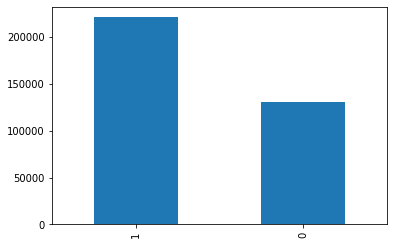

In [114]:
# DATA TYPE별 VISUALIZATION


x_train['d_l_match_yn'].value_counts().plot.bar()

<AxesSubplot:>

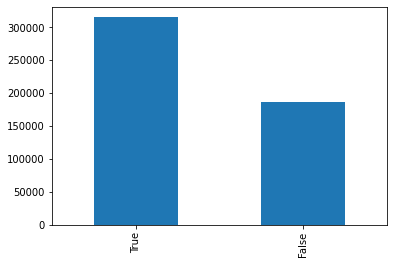

In [115]:
#
train_data['d_l_match_yn'].value_counts().plot.bar()

In [134]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,contents_attribute_h_l,contents_attribute_h_m,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,attr_a_1_mean_encode,attr_b_mean_encode,prefer_e_mean_encode,attr_e_mean_encode
66599,0,0,0,0,0,0,1,6,4,1,...,277,547,763,760,759,2006,0.515074,0.500850,0.531888,0.506072
363576,1,0,0,1,1,1,2,0,2,5,...,58,373,407,407,407,2006,0.493002,0.503328,0.488677,0.498611
278571,0,0,0,0,0,0,1,1,2,5,...,226,514,561,544,527,2006,0.497688,0.503328,0.488677,0.504105
160686,1,0,0,0,0,0,1,4,2,1,...,94,403,668,667,651,2006,0.483610,0.503328,0.500543,0.498611
208443,1,0,0,0,0,0,1,1,4,1,...,94,404,1580,1579,1572,2016,0.497688,0.500850,0.500543,0.506072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251110,1,0,0,1,1,1,1,3,2,5,...,94,418,1647,1646,1645,2017,0.486858,0.503328,0.500543,0.498611
467475,1,1,0,1,1,1,1,6,4,1,...,94,422,936,931,930,2009,0.515074,0.500850,0.652376,0.555721
36195,1,0,0,0,0,0,2,0,2,1,...,94,422,1807,1806,1752,2019,0.493002,0.503328,0.500543,0.498611
387719,1,0,0,1,1,1,1,5,3,1,...,94,421,1812,1811,1810,2020,0.496374,0.487071,0.500543,0.498611


In [ ]:
# 일치 비율 봐야된다

Text(0.5, 0, 'match_yn-target Distribution')

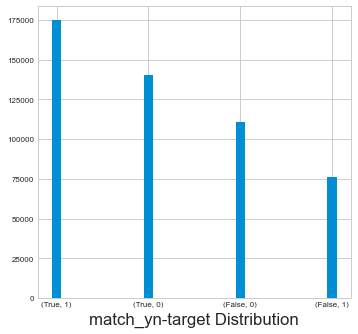

In [169]:
plt.subplots(len_cols,2 figsize=(5,5))
for col in cols:

plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(5,5))
plt.bar(index,train_data[['d_l_match_yn']].value_counts(),width=0.1)
plt.xticks(index,train_data[['d_l_match_yn']].value_counts().index)
plt.xlabel('match_yn-target Distribution')

In [ ]:
index = np.arange(len(train_data[['d_l_match_yn','target']].value_counts().index))+ 0.3
plt.style.use(['seaborn-whitegrid'])
plt.figure(figsize=(5,5))
plt.bar(index,train_data[['d_l_match_yn','target']].value_counts(),width=0.1)
plt.xticks(index,train_data[['d_l_match_yn','target']].value_counts().index)
plt.xlabel('match_yn-target Distribution')

In [8]:
import matplotlib.pyplot as plt
plt.pie(train_data['d_m_match_yn'], labels=train_data['d_m_match_yn'].index)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1208f4ca0> (for post_execute):


KeyboardInterrupt: 

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,1,46,147,145,4,1,1,251,49,258,3,2,5,1,1,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [ ]:
# category 는 feature 상관관계 잘 하지 않고 연속형 변수에서 많이 한다

In [ ]:
labels = ['초코','딸기','치즈','생크림']
frequency = [40,30,20,10]
cake = DataFrame({'frequency':frequency}, index = labels)

In [17]:
cols = train_data.columns

In [21]:
len(cols)//2

15

/var/folders/c6/2j22b1rd02778st12c0mcr3w0000gn/T/ipykernel_45084/3207449361.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.pie(train_data[col].astype(np.int).value_counts(),labels=train_data[col].value_counts().index)


NameError: name 'ax_idx' is not defined

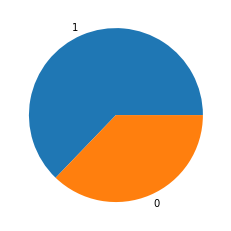

In [43]:
len(cols)

30

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


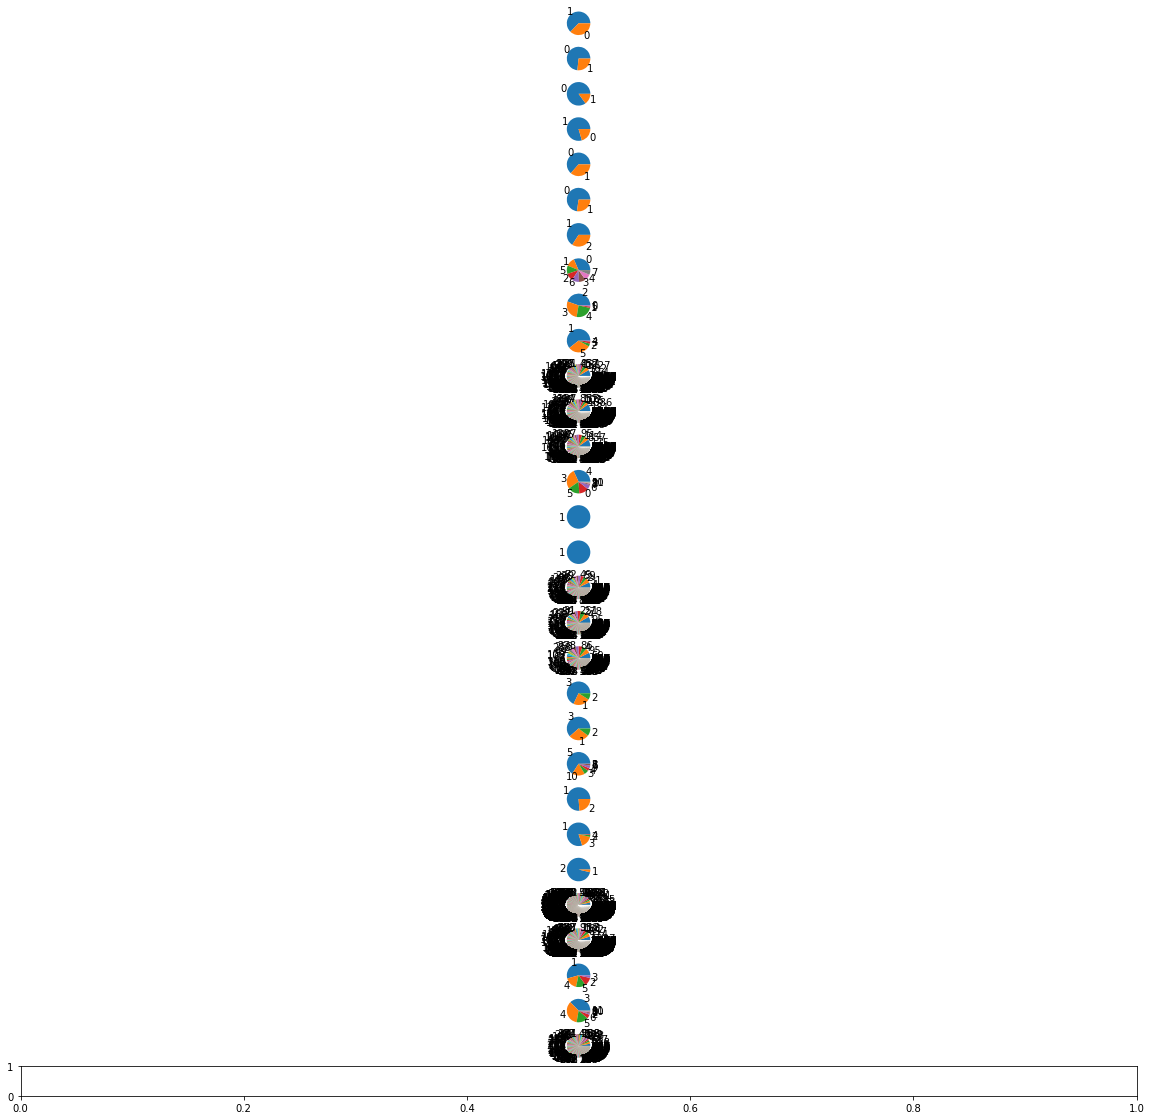

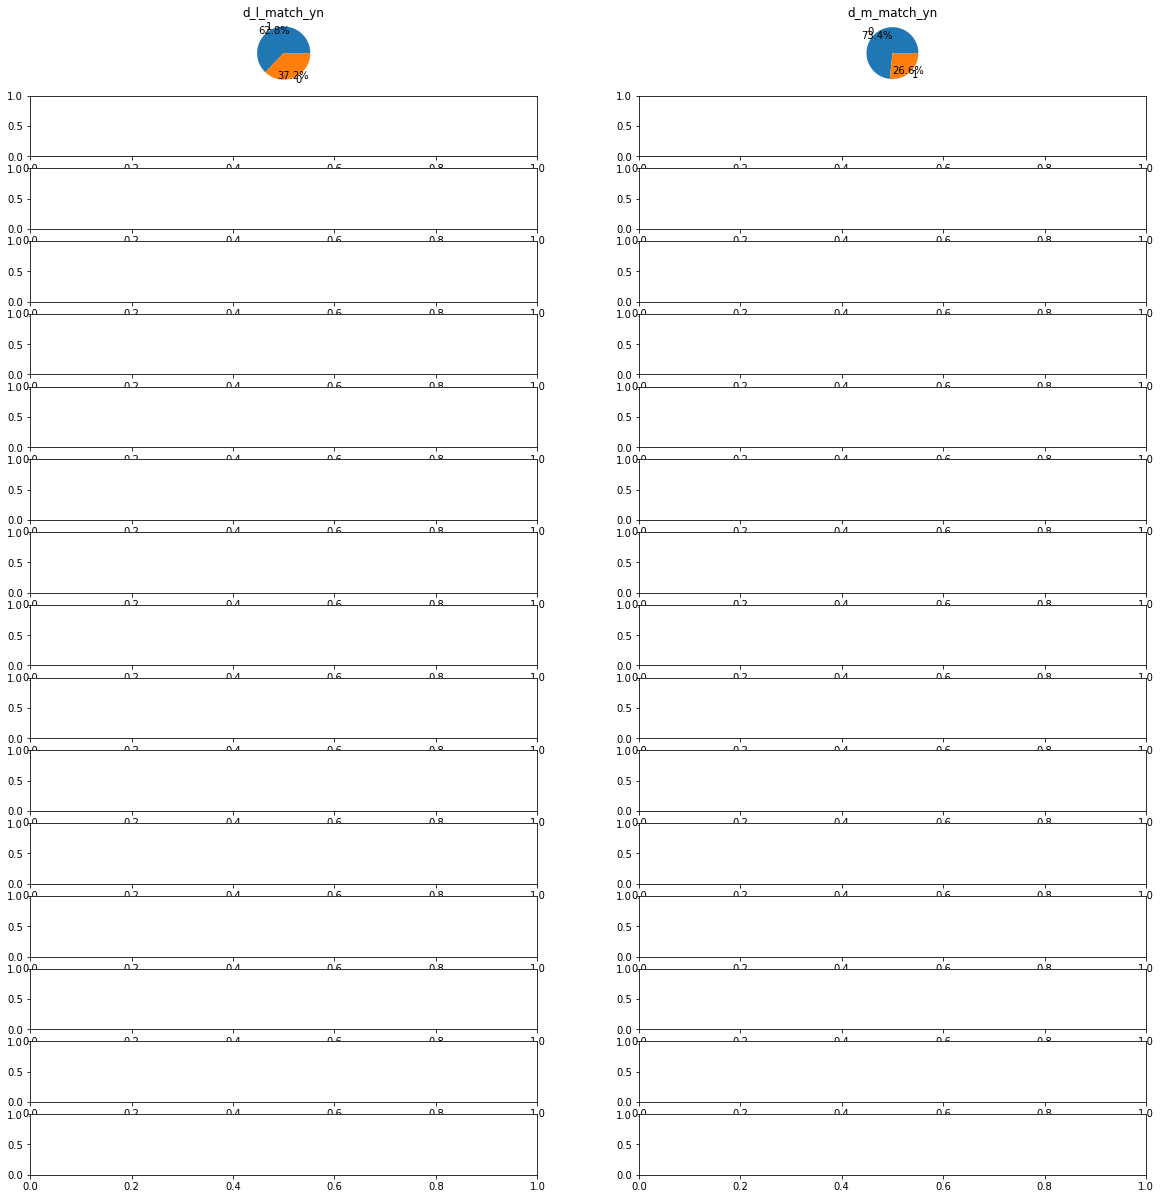

In [61]:
r = np.random.rand(len(cols))*0.8+0.6
fig, axes=  plt.subplots(len(cols)//2+1,2,figsize=(20,20))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9)
#for i in range(len(cols)//2+1):
#    for j in range(2):
for i, ax in enumerate(axes.flatten()):
    col = cols[idx]
    ax.pie(train_data[col].value_counts(),labels=train_data[col].value_counts().index,radius=r[i], autopct="%.1f%%",pctdistance=0.9)
    ax.set_title(col)
    idx+=1
    if idx >= 2:
        break

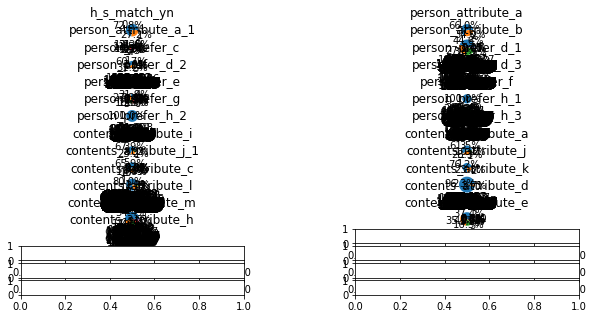

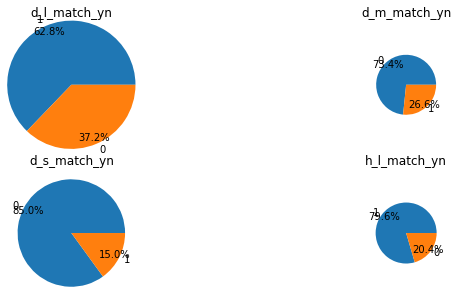

In [67]:
idx = 0
r = np.random.rand(len(cols))*0.8+0.6
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.5) # subplot간의 너비 간격 조절
for i, ax in enumerate(axes.flatten()):
    col = cols[idx]
    ax.pie(train_data[col].value_counts(),labels=train_data[col].value_counts().index,radius=r[i], autopct="%.1f%%",pctdistance=0.9)
    ax.set_title(col)
    idx+=1
    if idx >= len(cols):
        break

In [69]:
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features

NameError: name 'data' is not defined

In [77]:
train_data = train_data.drop(['id','person_rn','contents_rn','contents_open_dt'],axis=1)

In [79]:
target = train_data['target']

In [85]:
bestfeatures = SelectKBest(score_func=chi2, k=10)

In [86]:
fit = bestfeatures.fit(train_data,target)


In [87]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_data.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                   Specs          Score
26  contents_attribute_d  710648.337579
30                target  251106.000000
10     person_prefer_d_1  139277.951935
11     person_prefer_d_2  121750.746625
12     person_prefer_d_3   92596.953925
25  contents_attribute_l   76285.010872
16     person_prefer_h_1   68778.519806
29  contents_attribute_h   64351.442704
17     person_prefer_h_2   41667.363362
18     person_prefer_h_3   29968.002064


In [90]:
# target 제외하면 역시 d feature가 가장 중요도와 상관관계가 높기는 하다

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

[8.40602329e-03 4.77444141e-03 1.23902021e-03 6.14313207e-04
 3.86170590e-04 3.16683737e-04 4.95613066e-04 1.13291785e-03
 9.75840758e-04 8.13155962e-04 1.76690801e-03 1.51243832e-03
 1.53162124e-03 1.23918063e-03 0.00000000e+00 0.00000000e+00
 1.40101205e-03 1.32625697e-03 1.19505836e-03 7.42487127e-04
 8.30375669e-04 2.17441787e-03 6.78673455e-04 1.21227738e-03
 3.30611556e-04 1.78679537e-03 2.32251439e-03 1.03527626e-03
 1.15309081e-03 1.58927709e-03 9.57017547e-01]


ValueError: Length of passed values is 31, index implies 30.

[0.01459802 0.00804348 0.00548059 0.00872506 0.00795813 0.00844699
 0.01750409 0.04971053 0.04343088 0.02980488 0.06076899 0.06330049
 0.06061481 0.05272601 0.         0.         0.05345749 0.05798494
 0.05489668 0.0299279  0.02715487 0.02200657 0.00526921 0.01748333
 0.00672822 0.07351139 0.06833268 0.03871342 0.04968519 0.06373516]


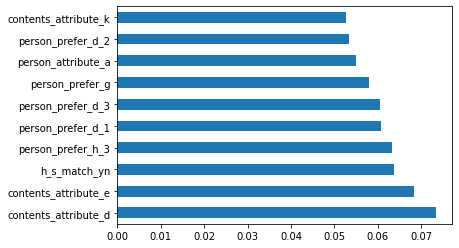

In [ ]:
train_data

[0.01440286 0.00814972 0.00565717 0.0086553  0.00798567 0.00826816
 0.01776295 0.04995898 0.04336464 0.02965986 0.06068782 0.06330444
 0.06060613 0.05307198 0.         0.         0.05329715 0.05766673
 0.05457124 0.02997283 0.02782597 0.0225073  0.0056998  0.01676249
 0.00676244 0.0732641  0.06848777 0.03839471 0.04971053 0.06354127]


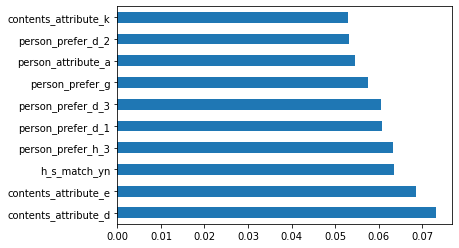

In [100]:
model.fit(train_data,target)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
exclude_target = list(set(train_data.columns.tolist())- set(['target']))
feat_importances = pd.Series(model.feature_importances_, index=exclude_target)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [112]:
feat_importances.nlargest(20)

contents_attribute_d      0.073264
contents_attribute_e      0.068488
h_s_match_yn              0.063541
person_prefer_h_3         0.063304
person_prefer_d_1         0.060688
person_prefer_d_3         0.060606
person_prefer_g           0.057667
person_attribute_a        0.054571
person_prefer_d_2         0.053297
contents_attribute_k      0.053072
contents_attribute_j_1    0.049959
contents_attribute_l      0.049711
contents_attribute_i      0.043365
d_l_match_yn              0.038395
person_attribute_b        0.029973
d_m_match_yn              0.029660
contents_attribute_j      0.027826
person_attribute_a_1      0.022507
contents_attribute_a      0.017763
person_prefer_f           0.016762
dtype: float64

<AxesSubplot:ylabel='Frequency'>

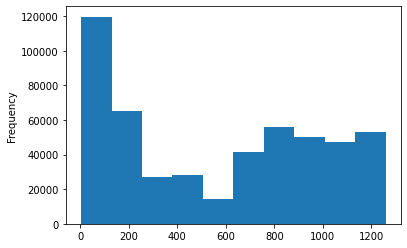

In [118]:
# top feature importance hist
train_data[feat_importances.nlargest(20).index[0]].plot.hist()

In [131]:
# target 분류값이 높은 속성 raw만 취한다 ? 속성별 분류해서 합치기 ?
# 피쳐별 target 차가 큰 속성값들을 위주로 활용하는 게 좋을 듯하다 대 중소 세분류 라임로봇 카테고리분류에서 아이디어
train[[feat_importances.nlargest(20).index[0],'target']].value_counts().sort_index()[:20]

contents_attribute_d  target
4                     0           5
5                     0          17
                      1          18
7                     0          10
8                     0         197
                      1         234
9                     0          48
                      1          59
10                    0          90
                      1         165
11                    0          11
                      1          15
12                    0         126
                      1         235
13                    0          42
                      1          40
14                    0           9
                      1          21
15                    0          13
                      1           7
dtype: int64

In [ ]:
train_data[[feat_importances.nlargest(20).index[0],'target']]

In [140]:
train_data

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65
501949,True,False,False,True,False,False,1,1,2,1,46,147,145,4,1,1,251,49,258,3,2,5,1,1,2,660,147,3,4,259


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
# !pip install iterative-stratification
# import joblib

In [135]:
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [136]:
# mlsk = MultilabelStratifiedKFold( random_state=42, n_splits=5)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [138]:
# train_data

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65
501949,True,False,False,True,False,False,1,1,2,1,46,147,145,4,1,1,251,49,258,3,2,5,1,1,2,660,147,3,4,259


In [ ]:
# for i , (trn_idx, vid,idx) in enumerate(mlsk.split(train_data,target)):
#     train_data.loc[trn_idx,'fold'] = i

In [ ]:
# train_data['fold'].value_counts()
# from tqdm import tqdm

CPU times: user 44.4 ms, sys: 3.1 ms, total: 47.5 ms
Wall time: 46.5 ms


<AxesSubplot:>

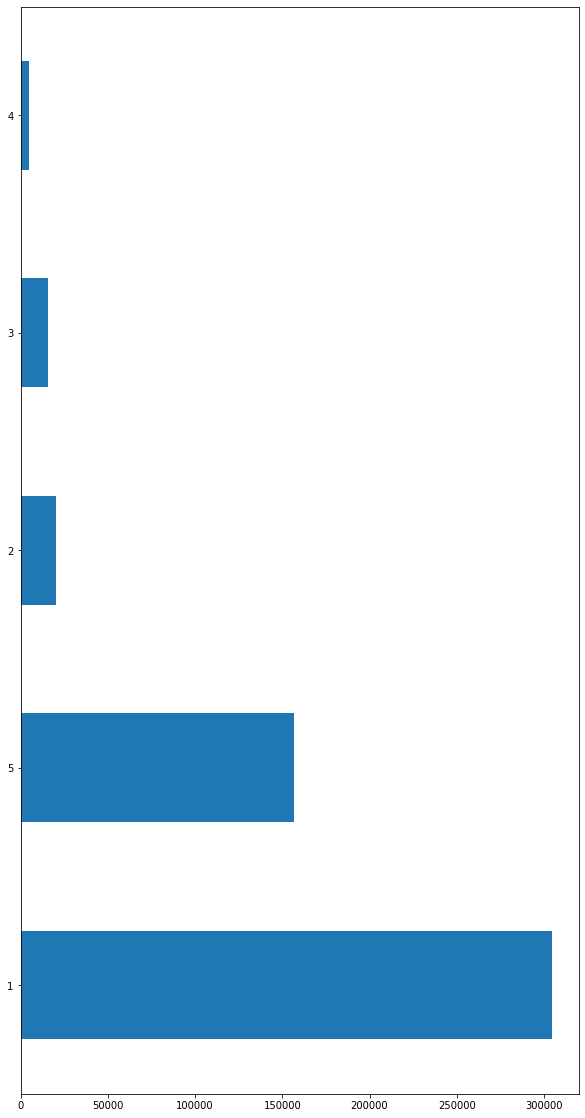

In [139]:
# %%time
# plt.figure(figsize=(10,20))
# train_data['person_prefer_c'].value_counts().plot.barh()
# 각각의 feature 가 불균형하므로 stratifiedKFold를 적용해야한다

In [ ]:
# test = 'test'
#
# joblib.dump(train_data,f'train_data{test}.pkl')
# joblib.load(train_data,f'train_data{test}.pkl')

In [ ]:
# train_data['id'] = train_data['train_id'].apply(lambda x : x.split('_')[1])

In [ ]:
data_dir = './JobCare_data/'
# files = [fname for fname in filenames if 'csv' in fname]

In [ ]:
# import os

In [ ]:
# for file in files:
#     F = os.path.join(data_dir, file)
#     #file =joblib.load(F)
#     df_train = pd.read_parquet(F)
#     # numpy or pkl so fast don't pandas
#     img_ids = df_train['image_id'].values
#     img = df_train.iloc[:,1:].values
#     # 파일별로 row (이미지) 저장
#     for idx in

In [ ]:
#대 중 소 세 네 개의 카테고리 조합으로 타겟 예측

from itertools import combinations

In [108]:
train_data

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65
501949,True,False,False,True,False,False,1,1,2,1,46,147,145,4,1,1,251,49,258,3,2,5,1,1,2,660,147,3,4,259


In [107]:
list(combinations([col for col in train_data.columns if 'match_yn' in col],2))

[('d_l_match_yn', 'd_m_match_yn'),
 ('d_l_match_yn', 'd_s_match_yn'),
 ('d_l_match_yn', 'h_l_match_yn'),
 ('d_l_match_yn', 'h_m_match_yn'),
 ('d_l_match_yn', 'h_s_match_yn'),
 ('d_m_match_yn', 'd_s_match_yn'),
 ('d_m_match_yn', 'h_l_match_yn'),
 ('d_m_match_yn', 'h_m_match_yn'),
 ('d_m_match_yn', 'h_s_match_yn'),
 ('d_s_match_yn', 'h_l_match_yn'),
 ('d_s_match_yn', 'h_m_match_yn'),
 ('d_s_match_yn', 'h_s_match_yn'),
 ('h_l_match_yn', 'h_m_match_yn'),
 ('h_l_match_yn', 'h_s_match_yn'),
 ('h_m_match_yn', 'h_s_match_yn')]

In [ ]:
train_data

In [ ]:
np.asarray(exclude_target).shape

In [ ]:
# feature importance 모형 기반 추출,

In [ ]:
# 너무 길어지면 필연적으로 작아지니 나눠서 plot 한다

In [ ]:
# feature selection
# 통계기반, 모형기반
from sklearn.feature_selection import SelectKBest, chi2
feature_selector  = SelectKBest(chi2)